<h1>Spam Classification for Text Messages</h1>
<b>Éverton Bin</b><br>

<h2>Table of Contents</h2>
<ol>
    <a href = '#intro'><li><b>Introduction</b></li></a>
    <a href = '#lib'><li><b>Libraries</b></li></a>
    <a href = '#load'><li><b>Loading Data</b></li></a>
    <a href = '#wordcloud'><li><b>Word Cloud</b></li></a>
    <a href = '#model1'><li><b>CountVectorizer + Naive Bayes</b></li></a>
    <a href = '#model2'><li><b>Term Frequency - Inverse Document Frequency</b></li></a>
    <a href = '#characters'><li><b>Number of Characters</b></li></a>
    <a href = '#digits'><li><b>Number of Digits</b></li></a>
    <a href = '#nonwords'><li><b>Non-Words</b></li></a>
    <a href = '#model3'><li><b>Support Vector Machine + Number of Characters Feature</b></li></a>
    <a href = '#model4'><li><b>Logistic Regression + Number of Digits Feature</b></li></a>
    <a href = '#model5'><li><b>Logistic Regression + Non-Words Feature</b></li></a>
    <a href = '#conclusion'><li><b>Conclusion</b></li></a>
</ol>

<h2>1. Introduction</h2>
<p>
If you have an email account or a cell phone, I would say the probability that you have already received a spam message goes around 100%.
</p>
<p>
Although it seems pretty easy for a human to tell if it's spam or not, it doesn't seem so easy for the algorithms. We all had already rescued important messages from the trash box and still had to deal with inbox spam.
</p>
<p>
It happens because spam classification requires natural language processing: a natural task for humans, a complex task for algorithms.
</p>
<p>
In this project, we are going to dive into a dataset containing several text messages previously classified as spam or not, and our job is to train a model capable of identifying the patterns with the highest accuracy.
</p>
<p>
Some questions guiding us through this project:
    <li>Which would be the best approach to correctly classify spam: <b>bag-of-words</b> or evaluating <b>words' importance</b>?</li>
    <li>Are there significant differences between spam and not spam messages, considering the <b>length of the text</b>?</li>
    <li>And what about the <b>number of digits</b> in the messages?</li>
    <li>Are there differences between spam and not spam if we analyze the number of <b>non-words</b> characters?</li>
    <li>By using <b>n-grams</b>, can we improve our model's performance?</li>
</p>
<p>
    This dataset <i>spam.csv</i> was made available by the <a href = "https://umich.edu/">University of Michigan</a>, through its <a href = "https://www.coursera.org/learn/python-text-mining">Applied Text Mining in Python</a> course made available through the Coursera platform.
</p>

<h2>2. Libraries</h2>

In [1]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, plot_confusion_matrix

import re
import warnings
warnings.filterwarnings('ignore')

<h2>3. Loading Data</h2>

In [2]:
# Reading the file:
spam_data = pd.read_csv('spam.csv')

# Changing label to 1-0 format (1 for spam, 0 for not spam):
spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


In [3]:
# Checking for number of observations:
print('This dataset contains {} labeled text messages.'.format(spam_data.shape[0])) 

This dataset contains 5572 labeled text messages.


In [4]:
# Checking for percentage of spam observations:
spam_perc = (spam_data['target'].mean())*100
print('{}% of the text messages are labeled as spam.'.format(round(spam_perc, 1)))

13.4% of the text messages are labeled as spam.


<p>
    Clearly, we have an unbalanced dataset (fewer spam observations in comparison to not spam text messages).
</p>
<p>
    Let's check some random text messages to get a sense of their content:
</p>

In [5]:
# Separating spam from not spam data:
not_spam_text = spam_data.text[spam_data['target'] == 0].reset_index(drop = True)
spam_text = spam_data.text[spam_data['target'] == 1].reset_index(drop = True)

# Random int values:
not_spam_rand = np.random.randint(low = 0, high = len(not_spam_text), size = 3)
spam_rand = np.random.randint(low = 0, high = len(spam_text), size = 3)

print('\nNOT SPAM SAMPLES:')
for i in not_spam_rand:
    print(str(not_spam_text.iloc[i])+'\n')
    
print('SPAM SAMPLES:')
for i in spam_rand:
    print(str(spam_text.iloc[i])+'\n')


NOT SPAM SAMPLES:
Babe ! What are you doing ? Where are you ? Who are you talking to ? Do you think of me ? Are you being a good boy? Are you missing me? Do you love me ?

Shuhui has bought ron's present it's a swatch watch...

I can't make it tonight

SPAM SAMPLES:
important information 4 orange user 0789xxxxxxx. today is your lucky day!2find out why log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!

RCT' THNQ Adrian for U text. Rgds Vatian

\URGENT! This is the 2nd attempt to contact U!U have WON å£1000CALL 09071512432 b4 300603t&csBCM4235WC1N3XX.callcost150ppmmobilesvary. maxå£7. 50\""



<h2>4. Word Cloud</h2>
<p>
    Let's try word cloud visualization for spam and not spam to see if we can indentify important differences between these two types of text messages.
</p>
<p>
    <b>Not Spam</b> word cloud:
</p>

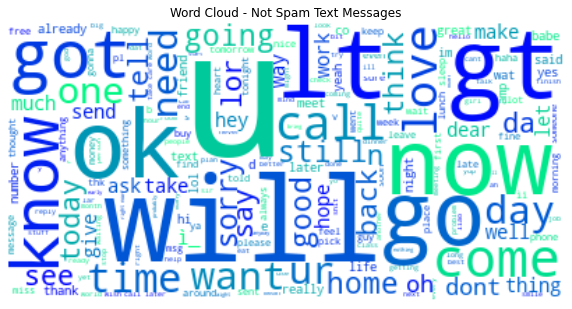

In [6]:
# Joining text messages classified as not spam:
text_nspam = " ".join(text.lower() for text in not_spam_text)

# Creating and generating a word cloud image for not spam text messages:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color = 'white', colormap = 'winter').generate(text_nspam)

# Displaying the image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud - Not Spam Text Messages')
plt.show()

<p>
    <b>Spam</b> word cloud:
</p>

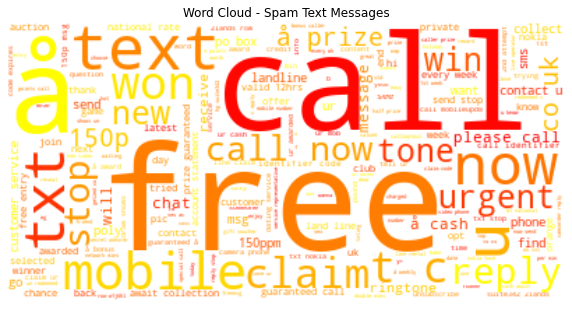

In [7]:
# Joining text messages classified as not spam:
text_spam = " ".join(text.lower() for text in spam_text)

# Creating and generating a word cloud image for not spam text messages:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color = 'white', colormap = 'autumn').generate(text_spam)

# Displaying the image:
plt.figure(figsize=[10,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud - Spam Text Messages')
plt.show()

<p>
    We can see some significant differences between the two types of messages.
</p>
<p>
    While <b>not spam</b> messages tend to present some classic shortened forms of words like "u", "ur", "lt", "gt", and words like "love", "ok", and "will", <b>spam</b> messages tend to present a call for action like "call", "call now", "reply", offering some advantages as we can see through the outstanding of the word "free".
</p>

<h2>5. CountVectorizer + Naive Bayes</h2>
<p>
    As a first approach, we will simply create a vector representing the occurrence of the words (bag-of-words), and then train and evaluate a Naive Bayes model for predicting whether a text message is spam or not.
</p>

In [8]:
# Splitting data into train and test sets:
X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], spam_data['target'], 
                                                    test_size = .25, random_state=0)

# Creating bag-of-words vector, considering only unigrams:
vect_1 = CountVectorizer(ngram_range = (1,1)).fit(X_train)

# Extracting tokens to check which ones are the longest:
X_train_tokens = vect_1.get_feature_names()
sorted_tokens = sorted(X_train_tokens, key = len, reverse = True)

print('Longest tokens in the bag-of-words:\n')
for i in range(5):
    print(str(i+1)+'. '+str(sorted_tokens[i])+'\n')

Longest tokens in the bag-of-words:

1. com1win150ppmx3age16subscription

2. minmoremobsemspobox45po139wa

3. 50pmmorefrommobile2bremoved

4. minmobsmorelkpobox177hp51fl

5. 150ppmpobox10183bhamb64xe



In [9]:
# Transforming X_train and X_test to vectorized matrix of words:
X_train_vect_1 = vect_1.transform(X_train)
X_test_vect_1 = vect_1.transform(X_test)

# Instatiating Naïve Bayes model:
multinom_nb = MultinomialNB(alpha = 0.1)

# Fitting model:
multinom_nb.fit(X_train_vect_1, y_train)

# Predictions for X_test:
y_pred_1 = multinom_nb.predict(X_test_vect_1)

# Evalutaing model on test set:
roc_score_1 = roc_auc_score(y_test, y_pred_1)

print('First Naive Bayes model achieved a Roc AUC score of {}.'.format(round(roc_score_1, 2)))

First Naive Bayes model achieved a Roc AUC score of 0.97.


<p>
    Our first model achieved an excellent overall score over the test set.
</p>
<p>
    For this Multinomial Naive Bayes model, we defined an alpha parameter of 0.1 to smooth the probability of a word that hasn't happened yet.
</p>
<p>
    Let's create a confusion matrix to see how well our model did considering the different classes:
</p>

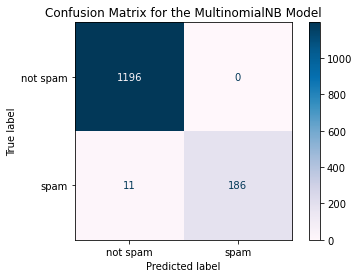

In [10]:
# Creating confusion matrix:
class_names = ['not spam', 'spam']
disp = plot_confusion_matrix(multinom_nb, X_test_vect_1, y_test, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu)
disp.ax_.set_title('Confusion Matrix for the MultinomialNB Model')
plt.show()

<p>
    As we can see, the first model did well for both classes (spam and not spam) even with the unbalanced dataset.
</p>
<p>
    It did especially well when classifying <i>not spam</i> text messages (all the text instances were correctly classified), but we would still have some spam messages not being classified as so, even though the majority of spam messages were correctly identified.
</p>
<p>
    Next, we are going to try some different approaches and models to see if we can get better evaluation scores.
</p>

<h2>6. Term Frequency - Inverse Document Frequency</h2>
<p>
    Istead of using the bag-of-words approach for the text's tokens, we are going to use the <b>Tf-idf</b> approach. It allows us to weight the terms based on how important they are to a document, instead of just counting occurrences.
</p>
<p>
    Features with low Tf-idf are either commonly used across all documents (text messages, in this case), or rarely used.
</p>

In [11]:
# Fitting Tfidf vector to X_train:
tfidf_vect = TfidfVectorizer().fit(X_train)
X_train_tfidf = tfidf_vect.transform(X_train)

# Getting list of feature names:
feat_names = tfidf_vect.get_feature_names()

# Getting list of tf-idf values:
tfidf_list = X_train_tfidf.max(0).toarray()[0]

# Creating a list for features and tf-idf scores:
tfidf_feat_scores = list()
for i in range(len(tfidf_list)):
    tfidf_feat_scores.append((tfidf_list[i], feat_names[i]))
tfidf_asc = sorted(tfidf_feat_scores)
tfidf_desc = sorted(tfidf_feat_scores, reverse = True)

print('Most important words:\n')
for i in range(5):
    print(str(i+1)+'. '+str(tfidf_desc[i][1])+'\n')

print('\nLess important words:\n')
for i in range(5):
    print(str(i+1)+'. '+str(tfidf_asc[i][1])+'\n')

Most important words:

1. yup

2. where

3. too

4. thanx

5. thank


Less important words:

1. aaniye

2. athletic

3. chef

4. companion

5. courageous



<p>
    Next step, we are going to train another Naive Bayes model, this time with the tf-idf score, instead of word occurences.
</p>
<p>
    Also, we are going to ignore terms with document frequency lower than 3:
</p>

In [12]:
# Creating tf-idf vector for X_train with min_df = 3:
tfidf_vec_2 = TfidfVectorizer(min_df = 3).fit(X_train)

# Transforming X_train and X_test to tf-idf matrix:
X_train_tfidf_2 = tfidf_vec_2.transform(X_train)
X_test_tfidf_2 = tfidf_vec_2.transform(X_test)

# Instatiating Naïve Bayes model:
multinom_nb_2 = MultinomialNB(alpha = 0.1)

# Fitting the model:
multinom_nb_2.fit(X_train_tfidf_2, y_train)

# Making predictions for X_train:
y_pred_2 = multinom_nb_2.predict(X_test_tfidf_2)

# Evaluating the model on train data:
roc_score_2 = roc_auc_score(y_test, y_pred_2)

print('Second Naive Bayes model achieved a Roc AUC score of {}.'.format(round(roc_score_2, 2)))

Second Naive Bayes model achieved a Roc AUC score of 0.94.


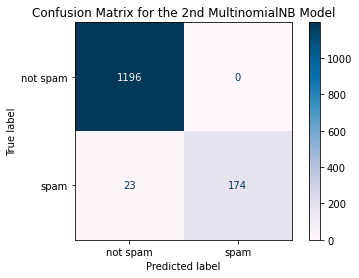

In [13]:
# Creating confusion matrix:
disp = plot_confusion_matrix(multinom_nb_2, X_test_tfidf_2, y_test, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu)
disp.ax_.set_title('Confusion Matrix for the 2nd MultinomialNB Model')
plt.show()

<p>
    We can see that this second approach didn't come up with better results in comparison to the first: more spam text messages were missclassified.
</p>
<p>
    Next, we are going to check if there are significant differences between spam and not spam messages, considering <b>number of characters</b> and <b>digits</b> and <b>non-words</b>.
</p>

<h2>7. Number of Characters</h2>
<p>
    We are going to compute the number of characters (document length) for each document and check for differences between the average length for spam and not spam messages:
</p>

In [14]:
# Separating spam_data into spam and not spam df:
df_list = [spam_data.text[spam_data['target'] == 0].reset_index(drop = True), 
           spam_data.text[spam_data['target'] == 1].reset_index(drop = True)]

# Creating a list for avg text length:
avg_text_len = list()

# Calculating average text length for spam and not spam texts:
for df in df_list:
    text_len = list()
    for i in range(0, len(df)):
        text_len.append(len(df.iloc[i]))
    avg_text_len.append(np.mean(text_len))
    
print('Not Spam messages have an average length of {}.\n'.format(round(avg_text_len[0], 2)))
print('Spam messages have an average length of {}.'.format(round(avg_text_len[1], 2)))

Not Spam messages have an average length of 71.02.

Spam messages have an average length of 138.87.


<p>
    We can see that the average length of text messages classified as spam is approximately twice the average length for not spam messages.
</p>
<p>
    It makes sense, considering that text messages are commonly used for quick information exchange, while spam messages intend to convince people to buy some product, or maybe to offer a service, and that could take more characters to be done.
</p>
<p>
    With that in mind, we are going to add the text messages' length as a feature in order to improve the model score.
</p>

<h2>8. Number of Digits</h2>
<p>
    The same logic used before for number of characters:
</p>

In [15]:
# Creating a list for avg text length:
avg_num_dig = list()

# Calculating average number of digits for spam and not spam texts:
for df in df_list:
    digit_count = 0
    for i in range(0, len(df)):
        for c in df.iloc[i]:
            if c.isdigit():
                digit_count += 1
    avg_digit = digit_count / len(df)
    avg_num_dig.append(avg_digit)
    
print('Not Spam messages have an average number of digits of {}.\n'.format(round(avg_num_dig[0], 2)))
print('Spam messages have an average number of digits of {}.'.format(round(avg_num_dig[1], 2)))

Not Spam messages have an average number of digits of 0.3.

Spam messages have an average number of digits of 15.76.


<p>
    Again, we can see a significant difference between spam and not spam messages, considering the average number of digits. We are also adding number of digits as a feature, and see if we can improve the model score.
</p>
<p>
    Next, we are going to check for differences by observing the number of non-word characters - anything different from alphanumeric characters.
</p>

<h2>9. Non-Words</h2>

In [16]:
# Creating a list for avg non-word:
avg_non_word = list()

# Calculating average number of non-words for spam and not spam texts:
for df in df_list:
    non_word_list = list()
    for i in range(0, len(df)):
        non_word_len = len(re.findall(r'\W', df.iloc[i]))
        non_word_list.append(non_word_len)
    avg_non_word_char = np.mean(non_word_list)
    avg_non_word.append(avg_non_word_char)

print('Not Spam messages have an average non-word characters of {}.\n'.format(round(avg_non_word[0], 2)))
print('Spam messages have an average non-word characters of {}.'.format(round(avg_non_word[1], 2)))

Not Spam messages have an average non-word characters of 17.29.

Spam messages have an average non-word characters of 29.04.


<p>
    Although the difference doesn't seem to be as significative as the number of characters and digits, the average number of non-word characters still presents a significant difference for spam and not spam messages.
</p>
<p>
    We are adding this information as a new feature in order to improve our model performance.
</p>
<p>
    We are creating the function <b>add_feature()</b> to help us adding the new features together with the word matrix:
</p>

In [17]:
def add_feature(X, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

<h2>10. Support Vector Machine + Number of Characters Feature</h2>
<p>
    We are not going to add the new features at once. Let's try different models and features to see what we can get.
</p>
<p>
    First, we are adding the number of characters as a new feature, and training a SVC model. From now on, we are setting the minimum of 5 occurences for not ignoring the term:
</p>

Support Vector Machine model achieved a Roc AUC score of 0.97.


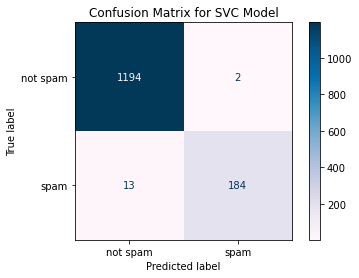

In [18]:
# Creating tf-idf vector for X_train with min_df = 5:
tfidf_vec_3 = TfidfVectorizer(min_df = 5). fit(X_train)

# Transforming X_train and X_test to tf-idf matrix:
X_train_tfidf_3 = tfidf_vec_3.transform(X_train)
X_test_tfidf_3 = tfidf_vec_3.transform(X_test)

# Creating a list of documents length both for train and set sets:
# train:
train_text_len = list()
for i in range(0, len(X_train)):
    train_text_len.append(len(X_train.iloc[i]))
# test:
test_text_len = list()
for i in range(0, len(X_test)):
    test_text_len.append(len(X_test.iloc[i]))

# Adding length of document as a feature:
X_train_3 = add_feature(X_train_tfidf_3, train_text_len)
X_test_3 = add_feature(X_test_tfidf_3, test_text_len)

# Instatiating SVC model:
svc_model_3 = SVC(C = 10000)

# Fitting model to train data:
svc_model_3.fit(X_train_3, y_train)

# Predicting for test set:
y_pred_3 = svc_model_3.predict(X_test_3)

# Evaluating on test set:
roc_score_3 = roc_auc_score(y_test, y_pred_3)

print('Support Vector Machine model achieved a Roc AUC score of {}.'.format(round(roc_score_3, 2)))

# Confusion matrix:
disp = plot_confusion_matrix(svc_model_3, X_test_3, y_test, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu)
disp.ax_.set_title('Confusion Matrix for SVC Model')
plt.show()

<p>
    We achieved a good perfomance, but still not better than our first one. For the first time we had some not spam messages missclassified.
</p>

<h2>11. Logistic Regression + Number of Digits Feature</h2>
<p>
    Besides the <i>min_df</i> parameter set to 5, we are setting word <i>n-grams</i> from 1 to 3.
</p>
<p>
    We are now training a Logistic Regression Model with regularization set to 100, including the number of digits feature:
</p>

First Logistic Regression model achieved a Roc AUC score of 0.98.


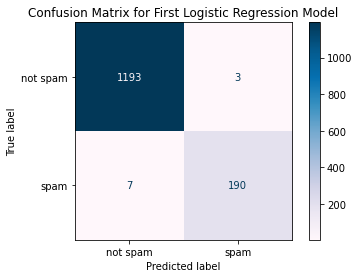

In [19]:
# Creating tf-idf vector for X_train with min_df = 5 and 1-3 n-grams:
tfidf_vec_4 = TfidfVectorizer(min_df = 5, ngram_range = (1,3)). fit(X_train)

# Transforming X_train and X_test to tf-idf matrix:
X_train_tfidf_4 = tfidf_vec_4.transform(X_train)
X_test_tfidf_4 = tfidf_vec_4.transform(X_test)

# Creating a list of number of digits per document for train and set sets:
# train:
digit_count_train = list()
for i in range(0, len(X_train)):
    doc_digit_count = 0
    for c in X_train.iloc[i]:
        if c.isdigit():
            doc_digit_count += 1
    digit_count_train.append(doc_digit_count)
# test:
digit_count_test = list()
for i in range(0, len(X_test)):
    doc_digit_count = 0
    for c in X_test.iloc[i]:
        if c.isdigit():
            doc_digit_count += 1
    digit_count_test.append(doc_digit_count)
    
# Adding length of document as a feature:
X_train_4 = add_feature(X_train_tfidf_4, train_text_len)
X_test_4 = add_feature(X_test_tfidf_4, test_text_len)

# Adding number of digits as a feature:
X_train_4 = add_feature(X_train_4, digit_count_train)
X_test_4 = add_feature(X_test_4, digit_count_test)

# Instatiating Logistic Regression model:
lr_model_4 = LogisticRegression(C = 100)

# Fitting model to train data:
lr_model_4.fit(X_train_4, y_train)

# Predicting for test set:
y_pred_4 = lr_model_4.predict(X_test_4)

# Evaluating on test set:
roc_score_4 = roc_auc_score(y_test, y_pred_4)

print('First Logistic Regression model achieved a Roc AUC score of {}.'.format(round(roc_score_4, 2)))

# Confusion matrix:
disp = plot_confusion_matrix(lr_model_4, X_test_4, y_test, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu)
disp.ax_.set_title('Confusion Matrix for First Logistic Regression Model')
plt.show()

<p>
    Finally, we achieved some improvement while classifying spam messages. In the other hand, we still have some mistakes when classifying not spam messages, which didn't happen in our first Naive Bayes model.
</p>

<h2>12. Logistic Regression + Non-Words Feature</h2>
<p>
    For our last attempt, we are going back to the <i>CountVectorizer</i> approach, since it gave us better performance given the first model we have tried.
</p>
<p>
   We are changing <i>min_df</i> parameter to 3, <i>n-grams</i> will be kept from 1 to 3, and we are are also including the non-word feature:
</p>

Second Logistic Regression model achieved a Roc AUC score of 0.98.


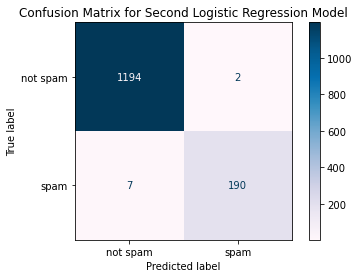

In [20]:
# Creating vector for X_train with min_df = 3 and 1-3 n-grams:
vect_5 = CountVectorizer(min_df = 3, ngram_range = (1,3)). fit(X_train)

# Transforming X_train and X_test to tf-idf matrix:
X_train_vect_5 = vect_5.transform(X_train)
X_test_vect_5 = vect_5.transform(X_test)

# Creating a list of number of non-word characters per document for train and set sets:
# train:
non_word_train = list()
for i in range(0, len(X_train)):
    non_word_len = len(re.findall(r'\W', X_train.iloc[i]))
    non_word_train.append(non_word_len)
    
# test:
non_word_test = list()
for i in range(0, len(X_test)):
    non_word_len = len(re.findall(r'\W', X_test.iloc[i]))
    non_word_test.append(non_word_len)

# Adding length of document as a feature:
X_train_5 = add_feature(X_train_vect_5, train_text_len)
X_test_5 = add_feature(X_test_vect_5, test_text_len)

# Adding number of digits as a feature:
X_train_5 = add_feature(X_train_5, digit_count_train)
X_test_5 = add_feature(X_test_5, digit_count_test)

# Adding number of non-word characteres as a feature:
X_train_5 = add_feature(X_train_5, non_word_train)
X_test_5 = add_feature(X_test_5, non_word_test)

# Instatiating Logistic Regression model:
lr_model_5 = LogisticRegression(C = 100)

# Fitting model to train data:
lr_model_5.fit(X_train_5, y_train)

# Predicting for test set:
y_pred_5 = lr_model_5.predict(X_test_5)

# Evaluating on test set:
roc_score_5 = roc_auc_score(y_test, y_pred_5)

print('Second Logistic Regression model achieved a Roc AUC score of {}.'.format(round(roc_score_5, 2)))

# Confusion matrix:
disp = plot_confusion_matrix(lr_model_5, X_test_5, y_test, 
                             display_labels = class_names, 
                             cmap=plt.cm.PuBu)
disp.ax_.set_title('Confusion Matrix for Second Logistic Regression Model')
plt.show()

<p>
    We could improve our first Logistic Regression model by reducing in one its mistakes while classifying not spam messages.
</p>

<h2>13. Conclusion</h2>

<p>
    Overall, the last Logistic Regression model would be our best model, since the mistakes were not concentrated over one single label. However, since the model would be responsible for filtering messages according to its classification, our first Naive Bayes model would be considered as the most appropriate for the job.
</p>
<p>
    If, in one hand, some spam messages would still achieve its recipient, in the other hand, not spam messages would not be blocked, and the reciever would not take the risk of missing important regular messages.
</p>
<p>
    Text can be worked in several ways, by setting values for n-grams, creating new features, counting occurences or using word importance scores, besides the different approaches when applying different machine learning algorithms. In this project, we could see that the simplest approach ended up achieving the best result.
</p>